# Positively-Toned Text Generator

Transformer with Encoder Layers & Decoder Layers

In [1]:
import os
import pathlib

# Deep Learning
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torchvision

# General
from tqdm import tqdm
import pandas as pd
import numpy as np

# Data visualization
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

# Device Setting
if torch.cuda.is_available():
  device = torch.device("cuda:0")
  print("GPU")
else:
  device = torch.device("cpu")
  print("CPU")

GPU


### Import tokenizer from huggingface

In [2]:
from huggingface_hub import notebook_login
notebook_login()

In [3]:
!pip install datasets tokenizers

# Huggingface
from transformers import BertTokenizer

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 510.5/510.5 kB 7.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 9.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 13.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 10.5 MB/s eta 0:00:00


In [140]:
# Configuration

def get_config(num_epochs, d_model, h, depth, vocab_size):
  return{
      "train_batch_size": 8,
      "test_batch_size": 1,
      "num_epochs": num_epochs,
      "lr": 3e-4,
      "seq_len": 256,
      "d_model": d_model,
      "h": h,
      "depth" : depth,
      "dropout": 0.2,
      "num_classes": vocab_size,
      "checkpoint": 'bert-base-uncased'
  }


## Load dataset

In [33]:
dataset = pd.read_csv('toxic_reframed.csv')

print(f"Data Generated by OpenAI API shape: {dataset.shape}")
print(dataset['reframed_text'].head())

errors = dataset[dataset['reframed_text'].isna()].index
errors = errors.tolist()
print(f"Error code: 400 occured on {len(errors)} indices")

dataset = dataset.dropna()
print(f"After dropping errors: {dataset.shape}")

X = dataset['comment_text']
y = dataset['reframed_text']


Data Generated by OpenAI API shape: (10559, 2)
0    Please kindly refrain from distracting me whil...
1    It seems like there was some misunderstanding ...
2    How about: "Please remember to always communic...
3    Seize the day and enjoy yourself. Indulge in y...
4    It seems like you may be having some issues wi...
Name: reframed_text, dtype: object
Error code: 400 occured on 37 indices
After dropping errors: (10522, 2)


In [228]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
vocab_size = tokenizer.vocab_size
config = get_config(5, 256, 64, 3, vocab_size) #(num_epochs, d_model, h, depth, vocab_size)

print(f'Pre-trained Tokenizer below: \n {tokenizer}')

source = list(X[:5].values)
target = list(y[:5].values)

print(f'Target: {target}')

encoded_sources = tokenizer(source, padding=True, truncation=True, return_tensors='pt')
encoded_targets = tokenizer(target, padding=True, truncation=True, return_tensors='pt')

src_input_ids = encoded_sources['input_ids']
src_token_type_ids = encoded_sources['token_type_ids']
src_attention_mask = encoded_sources['attention_mask']

print(f'Source: Input Ids: {src_input_ids}')
print(f'Source: Token type Ids: {src_token_type_ids}')
print(f'Source: Attention masks: {src_attention_mask}')

tgt_input_ids = encoded_sources['input_ids']
tgt_token_type_ids = encoded_sources['token_type_ids']
tgt_attention_mask = encoded_sources['attention_mask']

print(f'Target: Input Ids: {tgt_input_ids}')
print(f'Target: Token type Ids: {tgt_token_type_ids}')
print(f'Target: Attention masks: {tgt_attention_mask}')


# Decode
# tokenizer.decode() is designed to work with a single sequence at a time.
src_list = src_input_ids.tolist()
decoded_texts = [tokenizer.decode(ids) for ids in src_list]



Pre-trained Tokenizer below: 
 BertTokenizer(name_or_path='bert-base-uncased', vocab_size=30522, model_max_length=512, is_fast=False, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'}, clean_up_tokenization_spaces=True),  added_tokens_decoder={
	0: AddedToken("[PAD]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	100: AddedToken("[UNK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	101: AddedToken("[CLS]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	102: AddedToken("[SEP]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	103: AddedToken("[MASK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
}
Target: ['Please kindly refrain from distracting me while I am working. Thank you for your understa

In [229]:
from torch.utils.data import Dataset

class PositiveDataset(Dataset):
  def __init__(self, source, target, config):
    super().__init__()

    self.txt = source.values
    self.target = target.values

    self.seq_len = config['seq_len']
    self.h = config['h']
    self.tokenizer = BertTokenizer.from_pretrained(config['checkpoint'])

  def __len__(self):
    return len(self.txt)

  def __getitem__(self, idx):
    source = str(self.txt[idx])
    target = str(self.target[idx])

    h = self.h
    seq_len = self.seq_len

    # tokenized_source
    tokenized_source = self.tokenizer(source,
                                     max_length = self.seq_len,
                                     padding='max_length',
                                     truncation = True
                                     )

    # encoder inputs
    encoder_input = torch.tensor(tokenized_source['input_ids'], dtype= torch.long)

    # source masks
    encoder_mask = torch.tensor(tokenized_source['attention_mask'], dtype= torch.long).unsqueeze(0)
    encoder_mask = encoder_mask.repeat(1, h, 1)
    encoder_mask = encoder_mask.expand(seq_len, h, seq_len)
    encoder_mask = encoder_mask.transpose(0,1).contiguous()

    # tokenized_target
    tokenized_target = self.tokenizer(target,
                                     max_length = self.seq_len,
                                     padding='max_length',
                                     truncation = True
                                     )

    # decoder inputs (should not be used in loss function. It's an input)
    decoder_input = torch.tensor(tokenized_target['input_ids'], dtype= torch.long)
    # remove special tokens for end of statement
    decoder_input = torch.where(decoder_input == 102, torch.tensor(0), decoder_input)

    # target_masks
    decoder_mask = torch.tensor(tokenized_target['attention_mask'], dtype= torch.long).unsqueeze(0)
    decoder_mask = decoder_mask.repeat(1, h, 1)
    decoder_mask = decoder_mask.expand(seq_len, h, seq_len)
    decoder_mask = decoder_mask.transpose(0,1).contiguous().type(torch.int)
    # target_masks must be causally masked
    decoder_mask = decoder_mask & torch.tril(torch.ones(h, seq_len, seq_len)).type(torch.int)

    # label (should be used in loss function)
    label = torch.tensor(tokenized_target['input_ids'], dtype= torch.long)
    # remove special tokens for start of statement
    label = torch.cat((label[1:], torch.tensor([0])))


    item = {
          'source_txt': source,
          'target_txt': target,
          'encoder_input': encoder_input,
          'encoder_mask': encoder_mask,
          'decoder_input': decoder_input,
          'decoder_mask': decoder_mask,
          'label' : label
    }

    return item

### Dataloader

In [ ]:
config = get_config(5, 256, 64, 3, vocab_size) #(num_epochs, d_model, h, depth, vocab_size)

source = X
target = y

train_loader = DataLoader(
    PositiveDataset(source, target, config),
    batch_size = config['train_batch_size'],
    shuffle=True,
    pin_memory = True
)

dataiter = iter(train_loader)
batch = next(dataiter)

for idx in range(len(batch['encoder_input'])):
  #print(f"source text: {batch['source_txt'][idx]}\n")
  print(f"target text: {batch['target_txt'][idx]}\n")
  print(f"encoder input: {batch['encoder_input'][idx]}\n")
  print(f"encoder mask: {batch['encoder_mask'].size()}\n")
  print(f"decoder input: {batch['decoder_input'][idx]}\n")
  print(f"decoder mask: {batch['decoder_mask'].size()}\n")
  print(f"label: {batch['label'][idx]}")



## Input Embedding & Positional Embedding

In [231]:
import math

class InputEmbedding(nn.Module):
  def __init__(self, vocab_size, d_model):
    super().__init__()
    self.vocab_size = vocab_size
    self.d_model = d_model
    self.embedding = nn.Embedding(vocab_size, d_model)

  def forward(self, x):
    return self.embedding(x) * (self.d_model ** 0.5)


class PositionalEmbedding(nn.Module):
  def __init__(self, d_model, seq_len):
    super().__init__()

    pe = torch.zeros(seq_len, d_model)

    pos = torch.arange(0, seq_len, dtype=torch.float).unsqueeze(1)
    div = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000) / d_model))

    pe[:,0::2] = torch.sin(pos*div)
    pe[:,1::2] = torch.cos(pos*div)
    pe = pe.unsqueeze(0)
    self.register_buffer('pe', pe)

  def forward(self, x):
    x = x + self.pe[:, :x.shape[1], :].requires_grad_(False)
    return x


### Check dimension for input embedding and positional embedding

In [232]:
tokenizer = BertTokenizer.from_pretrained(config['checkpoint'])
print(tokenizer)

input_embedding = InputEmbedding(tokenizer.vocab_size, config['d_model'])
positional_encoding = PositionalEmbedding(config['d_model'], config['seq_len'])


source = X
target = y

train_ds = PositiveDataset(source, target, config)
data = train_ds.__getitem__(1)

encoder_input = data['encoder_input']
decoder_input = data['decoder_input']

print(f"Source ids: {encoder_input}")
print(f"Source ids size: {encoder_input.size()}")


# train_ds.__getitem__(1)['source_ids'].unsqueeze(0) is needed only here.
# because when we use dataloader, it will return size ([1, 256]), not ([256])
src_emb = input_embedding(encoder_input.unsqueeze(0))
print(f"\nSource after embedded size: {src_emb.size()}")
src_pe = positional_encoding(src_emb)
print(f"Source after positional embedded size: {src_pe.size()}\n")
print(f"Source after positional embedding: {src_pe}\n")



tgt_emb = input_embedding(decoder_input.unsqueeze(0))
print(f"Target after embedded size: {tgt_emb.size()}")
tgt_pe = positional_encoding(tgt_emb)
print(f"Target after positional embedded size: {tgt_pe.size()}")


BertTokenizer(name_or_path='bert-base-uncased', vocab_size=30522, model_max_length=512, is_fast=False, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'}, clean_up_tokenization_spaces=True),  added_tokens_decoder={
	0: AddedToken("[PAD]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	100: AddedToken("[UNK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	101: AddedToken("[CLS]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	102: AddedToken("[SEP]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	103: AddedToken("[MASK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
}
Source ids: tensor([  101,  2017,  2024,  5637,  2030,  3424,  3366,  7382, 29050,  2078,
         1029, 28185,  2317,  6816,  203

## Feed Forward

In [235]:
class FeedForward(nn.Module):
  def __init__(self, config):
    super().__init__()
    self.d_model = config['d_model']
    self.d_ff = self.d_model * 4

    self.ffn = nn.Sequential(
        nn.Linear(self.d_model, self.d_ff),
        nn.ReLU(),
        nn.Linear(self.d_ff, self.d_model),
        nn.Dropout(config['dropout'])
    )

  def forward(self, x):
    return self.ffn(x)


## Multi-head Attention

In [236]:
class MultiHeadAttention(nn.Module):
  def __init__(self, config):
    super(MultiHeadAttention, self).__init__()

    self.d_model = config['d_model']
    self.h = config['h']

    assert self.d_model % self.h == 0, "d_model must be divisible by h"


    self.d_k = self.d_model // self.h
    # Query, key, value
    self.W_q = nn.Linear(self.d_model, self.d_model, bias=False)
    self.W_k = nn.Linear(self.d_model, self.d_model, bias=False)
    self.W_v = nn.Linear(self.d_model, self.d_model, bias=False)

    # Last Layer
    self.W_o = nn.Linear(self.d_model, self.d_model, bias=False)

    # dropout
    self.dropout = nn.Dropout(config['dropout'])

  def forward(self, q, k, v, mask):

    h = self.h
    d_k = self.d_k
    d_model = self.d_model

    query = self.W_q(q)
    key = self.W_k(k)
    value = self.W_v(v)

    # It's necessary since decode process will be (target, src_output, src_output, mask)
    # which means, q_seq_len and k_seq_len will be different.
    q_B, q_seq_len, _ = query.size()
    k_B, k_seq_len, _ = key.size()
    v_B, v_seq_len, _ = value.size()
    # size: (Batch, Seq_len, d_model) -> (Batch, Seq_len, h, d_model // h)
    query = query.view(q_B, q_seq_len, h, d_k)
    key = key.view(k_B, k_seq_len, h, d_k)
    value = value.view(v_B, v_seq_len, h, d_k)

    # (Batch, Seq_len, h, d_k) -> (Batch, h, Seq_len, d_k)
    # (Batch, h, Seq_len, d_k) -> (Batch * h, Seq_len, d_k)
    query = query.transpose(1,2).contiguous().view(q_B * h, q_seq_len, d_k)
    key = key.transpose(1,2).contiguous().view(k_B * h, k_seq_len, d_k)
    value = value.transpose(1,2).contiguous().view(v_B * h, v_seq_len, d_k)

    # Attention: W
    # paying attention to each sequences, therefore size should be (Batch *h, Seq_len, Seq_len)
    W = query @ key.transpose(1,2)
    W = W / (d_model ** 0.5)

    # If there is a mask, make masked spots -INF
    # seq_len must be equal to query's sequence length.
    if mask is not None:
      mask = mask.view(k_B * h, k_seq_len, k_seq_len) # (B, h, Seq_len, Seq_len) => (B * h, Seq_len, Seq_len)
      # It's for when we are generating new positive-toned manner text from the empty decoder_input
      if q_seq_len != k_seq_len:
        mask = mask[:,:q_seq_len,:]
      W = W.masked_fill_(mask == 0, float('-inf'))

    W = W.softmax(dim = -1)
    # drop out
    W = self.dropout(W)

    out = W @ value # (B * h, seq_len, d_k)
    B, Seq_len, d_k = out.size()
    B = B // h
    out = out.view(B, h, Seq_len, d_k)
    out = out.transpose(1,2).contiguous().view(B, Seq_len, h * d_k)
    return self.W_o(out)


## Encoder & Decoder

In [237]:
class EncoderBlock(nn.Module):
  def __init__(self, config):
    super(EncoderBlock, self).__init__()

    self.d_model = config['d_model']

    self.MultiHeadAttention = MultiHeadAttention(config)

    self.ln_1 = nn.LayerNorm(self.d_model)
    self.ln_2 = nn.LayerNorm(self.d_model)
    self.FeedForward = FeedForward(config)

  def forward(self, x, src_mask):
    x = x + self.MultiHeadAttention(x, x, x, src_mask)
    x = self.ln_1(x)
    x = x + self.FeedForward(x)
    x = self.ln_2(x)
    return x


In [238]:
class Encoder(nn.Module):
  def __init__(self, config):
    super(Encoder, self).__init__()

    self.depth = config['depth']
    self.blocks = nn.ModuleList([
        EncoderBlock(config) for _ in range(self.depth)
    ])
    self.blocks = nn.Sequential(*self.blocks)

  def forward(self, x, src_mask):
    for block in self.blocks:
      x = block(x, src_mask)
    return x




In [239]:
class DecoderBlock(nn.Module):
  def __init__(self, config):
    super(DecoderBlock, self).__init__()

    self.d_model = config['d_model']

    self.SelfHeadAttention = MultiHeadAttention(config)
    self.CrossHeadAttention = MultiHeadAttention(config)

    self.ln_1 = nn.LayerNorm(self.d_model)
    self.ln_2 = nn.LayerNorm(self.d_model)
    self.ln_3 = nn.LayerNorm(self.d_model)

    self.FeedForward = FeedForward(config)

  def forward(self, x, encoder_out, src_mask, tgt_mask):
    # x: target, in our case positively-toned comment
    x = x + self.SelfHeadAttention(x, x, x, tgt_mask)
    x = self.ln_1(x)
    x = x + self.CrossHeadAttention(x, encoder_out, encoder_out, src_mask)
    x = self.ln_2(x)
    x = x + self.FeedForward(x)
    x = self.ln_3(x)
    return x


In [240]:
class Decoder(nn.Module):
  def __init__(self, config):
    super(Decoder, self).__init__()

    self.depth = config['depth']

    self.blocks = nn.ModuleList([
        DecoderBlock(config) for _ in range(self.depth)
    ])
    self.blocks = nn.Sequential(*self.blocks)

  def forward(self, x, encoder_out, src_mask, tgt_mask):
    for block in self.blocks:
      x = block(x, encoder_out, src_mask, tgt_mask)
    return x

# Positive Generator

In [241]:
class PositiveGenerator(nn.Module):
  def __init__(self, config, vocab_size):
    super(PositiveGenerator, self).__init__()

    self.encoder = Encoder(config)
    self.decoder = Decoder(config)

    self.d_model = config['d_model']
    self.seq_len = config['seq_len']

    # Input Embedding for source and target
    self.src_embedding = InputEmbedding(vocab_size, self.d_model)
    self.tgt_embedding = InputEmbedding(vocab_size, self.d_model)

    # Positional Embedding for source and target
    self.src_pos_embedding = PositionalEmbedding(self.d_model, self.seq_len)
    self.tgt_pos_embedding = PositionalEmbedding(self.d_model, self.seq_len)

    self.norm = nn.LayerNorm(self.d_model)
    self.projection = nn.Linear(self.d_model, vocab_size)

  def encode(self, source, src_mask):
    source = self.src_embedding(source)
    source = self.src_pos_embedding(source)
    return self.encoder(source, src_mask)

  def decode(self, target, encoder_out, src_mask, tgt_mask):
    target = self.tgt_embedding(target)
    target = self.tgt_pos_embedding(target)
    return self.decoder(target, encoder_out, src_mask, tgt_mask)

  def forward(self, decoder_out):
    #out = self.norm(decoder_out)
    out = self.projection(decoder_out)
    return torch.log_softmax(out, dim=-1)


# TRAINING

{'train_batch_size': 8, 'test_batch_size': 1, 'num_epochs': 5, 'lr': 0.0003, 'seq_len': 256, 'd_model': 256, 'h': 64, 'depth': 3, 'dropout': 0.2, 'num_classes': 30522, 'checkpoint': 'bert-base-uncased'}
PositiveGenerator(
  (encoder): Encoder(
    (blocks): Sequential(
      (0): EncoderBlock(
        (MultiHeadAttention): MultiHeadAttention(
          (W_q): Linear(in_features=256, out_features=256, bias=False)
          (W_k): Linear(in_features=256, out_features=256, bias=False)
          (W_v): Linear(in_features=256, out_features=256, bias=False)
          (W_o): Linear(in_features=256, out_features=256, bias=False)
          (dropout): Dropout(p=0.2, inplace=False)
        )
        (ln_1): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
        (ln_2): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
        (FeedForward): FeedForward(
          (ffn): Sequential(
            (0): Linear(in_features=256, out_features=1024, bias=True)
            (1): ReLU()
          

Processing epoch 04: 100%|██████████| 1316/1316 [11:02<00:00,  1.99it/s, loss=0.370]


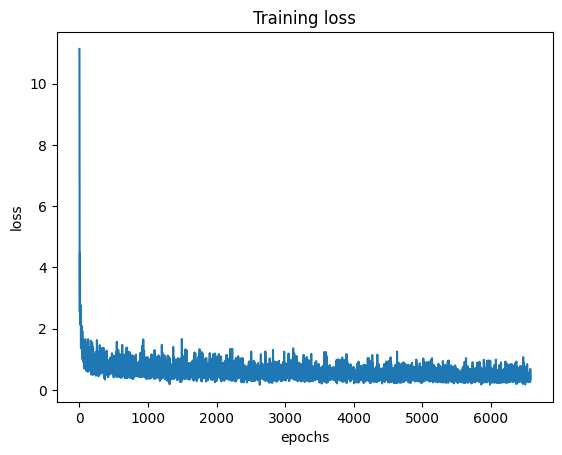

In [242]:


# path for saving model
path = "./PositiveGenerator"
pathlib.Path(f"./{path}/").mkdir(parents=True, exist_ok=True)


# tokenizer
tokenizer = BertTokenizer.from_pretrained(config['checkpoint'])

# configuration
vocab_size = tokenizer.vocab_size
config = get_config(5, 256, 64, 3, vocab_size) #(num_epochs, d_model, h, depth, vocab_size)
print(config)


# hyperparameters
lr = config['lr']
num_epochs = config['num_epochs']

# model, optim, loss (cross entropy loss)
model = PositiveGenerator(config, vocab_size).to(device)
print(model)
optimizer = torch.optim.Adam(model.parameters(), lr=config['lr'])
ce_loss = nn.CrossEntropyLoss()
Loss = []
# training
for epoch in range(num_epochs):
  model.train()
  batch_iterator = tqdm(train_loader, desc = f'Processing epoch {epoch:02d}')
  for batch in batch_iterator:
    # for encoder
    encoder_input = batch['encoder_input'].to(device)
    encoder_mask = batch['encoder_mask'].to(device)
    # for decoder
    decoder_input = batch['decoder_input'].to(device)
    decoder_mask = batch['decoder_mask'].to(device)

    # label for loss function
    label = batch['label'].to(device)

    B, seq_len = encoder_input.size()

    # forward pass
    # def encode(self, source, src_mask):
    encoder_out = model.encode(encoder_input, encoder_mask)
    # def decode(self, target, encoder_out, src_mask, tgt_mask):
    decoder_out = model.decode(decoder_input, encoder_out, encoder_mask, decoder_mask)
    out = model(decoder_out) # size:(Batch, Seq_len, tgt_vocab_size)

    out = out.view(B*seq_len, vocab_size)
    label = label.view(B*seq_len)

    loss = ce_loss(out, label)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    batch_iterator.set_postfix(loss=f"{loss.item():6.3f}")
    Loss.append(loss.item())
  torch.save(model.state_dict(), f'{path}/{epoch}.pth')

torch.save(model.state_dict(), f'{path}/pg_final_model_3_64_512.pth')


# Loss plot
plt.plot(Loss, linestyle='-')
plt.title('Training loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.show()


### Validation

In [ ]:
#validation


dataiter = iter(train_loader)
batch = next(dataiter)

with torch.no_grad():
  model.eval()

  encoder_input = batch['encoder_input'].to(device)
  encoder_mask = batch['encoder_mask'].to(device)
  # for decoder
  decoder_input = batch['decoder_input'].to(device)
  decoder_mask = batch['decoder_mask'].to(device)

  # label for loss function
  label = batch['label'].to(device)

  B, seq_len = encoder_input.size()

  # forward pass
  # def encode(self, source, src_mask):
  encoder_out = model.encode(encoder_input, encoder_mask)
  # def decode(self, target, encoder_out, src_mask, tgt_mask):
  decoder_out = model.decode(decoder_input, encoder_out, encoder_mask, decoder_mask)
  out = model(decoder_out) # size:(Batch, Seq_len, tgt_vocab_size)
  out = out.view(B*seq_len, vocab_size)

  label = label.view(B*seq_len)
  pred = torch.max(out, dim=-1).indices

  txt_pred = tokenizer.decode(pred).replace("[PAD]", "")
  print(f"\nOriginal comments: {batch['source_txt']}\n")
  print(f"Generated comments: {txt_pred}\n")
  print(f"Target comments: {batch['target_txt']}\n")


# Text Generation

In [280]:
config = get_config(5, 512, 32, 3, vocab_size) #(num_epochs, d_model, h, depth, vocab_size)

pg_model = PositiveGenerator(config, vocab_size).to(device)
pg_model.load_state_dict(torch.load(f'{path}/pg_final_model_3_32_512.pth',map_location=device))

# config
seq_len = config['seq_len']
h = config['h']

print(f"\nNumber of heads: {h}")
print(f"Sequence length: {seq_len}\n")

tokenized_source = tokenizer("stop editting to make incorrect information on wikipedia!!!", max_length = seq_len, padding='max_length', truncation=True, return_tensors='pt')

# source id
encoder_input = torch.tensor(tokenized_source['input_ids'], dtype=torch.long).to(device)
print(encoder_input)
# source mask
encoder_mask = torch.tensor(tokenized_source['attention_mask'], dtype= torch.long).unsqueeze(0).to(device)
encoder_mask = encoder_mask.repeat(1, h, 1)
encoder_mask = encoder_mask.expand(seq_len, h, seq_len)
encoder_mask = encoder_mask.transpose(0,1).contiguous()
# need unsqueeze here since we're not loading from dataloader
encoder_mask = encoder_mask.unsqueeze(0)

print(f"Source mask size: {encoder_mask.size()}")

with torch.no_grad():
  pg_model.eval()

  print(f"Source size: {encoder_input.size()}")
  encoder_output = pg_model.encode(encoder_input, encoder_mask)
  print(f"Encoder output size: {encoder_output.size()}")

  decoder_input = torch.empty(1,1).fill_(101).type_as(encoder_input).to(device)

  while decoder_input.size(1) < seq_len:
    # Decoder mask
    decoder_mask = torch.tril(torch.ones(h, decoder_input.size(1), decoder_input.size(1))).unsqueeze(0).type(torch.int).to(device)
    decoder_out = pg_model.decode(decoder_input, encoder_output, encoder_mask, decoder_mask)
    prob = pg_model(decoder_out[:,-1])
    _, next_word = torch.max(prob, dim=1)
    decoder_input = torch.cat([decoder_input, torch.empty(1, 1).type_as(encoder_input).fill_(next_word.item()).to(device)], dim=1)
    txt_pred = tokenizer.decode(next_word)

    if next_word == 102:
      break

src_list = decoder_input.tolist()
decoded_texts = [tokenizer.decode(ids) for ids in src_list]
print(decoded_texts)




Number of heads: 32
Sequence length: 256

tensor([[  101,  2644, 10086,  3436,  2000,  2191, 16542,  2592,  2006, 16948,
           999,   999,   999,   102,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
         

## Dimension check

### Check InputEmbedding & Positional Embedding

In [ ]:

tgt_embedding = InputEmbedding(vocab_size, d_model)
tgt_pos_embedding = PositionalEmbedding(d_model, seq_len)


x = tgt_embedding(decoder_input)
print(f"Decoder input size after Input Embedding: {x.size()}\n")

x = tgt_pos_embedding(x)
print(f"Decoder input size after Positional Embedding: {x.size()}\n")



target size input embedding: torch.Size([1, 2, 256])

target size positional embedding: torch.Size([1, 2, 256])



### Check Self-Head Attention part

In [ ]:
ln1 = nn.LayerNorm(d_model)

SHA_W_q = nn.Linear(d_model, d_model, bias=False)
SHA_W_k = nn.Linear(d_model, d_model, bias=False)
SHA_W_v = nn.Linear(d_model, d_model, bias=False)
SHA_W_o = nn.Linear(d_model, d_model, bias=False)

query = SHA_W_q(x)
key = SHA_W_k(x)
value = SHA_W_v(x)

print(f"query size: {query.size()}\n")
print(f"key size: {key.size()}\n")
print(f"value size: {value.size()}\n")

q_B, q_seq_len, _ = query.size()
k_B, k_seq_len, _ = key.size()
v_B, v_seq_len, _ = value.size()
# size: (Batch, Seq_len, d_model) -> (Batch, Seq_len, h, d_model // h)
query = query.view(q_B, q_seq_len, h, d_k)
key = key.view(k_B, k_seq_len, h, d_k)
value = value.view(v_B, v_seq_len, h, d_k)
print(f"query size: {query.size()}\n")
print(f"key size: {key.size()}\n")
print(f"value size: {value.size()}\n")

# size: (Batch, Seq_len, h, d_model // h) -> (B*h, seq_len, d_model//h)
query = query.transpose(1,2).contiguous().view(q_B * h, q_seq_len, d_k)
key = key.transpose(1,2).contiguous().view(k_B * h, k_seq_len, d_k)
value = value.transpose(1,2).contiguous().view(v_B * h, v_seq_len, d_k)

print(f"query size: {query.size()}\n")
print(f"key size: {key.size()}\n")
print(f"value size: {value.size()}\n")

W = query @ key.transpose(1, 2) / math.sqrt(d_k)
print(f"W before masking:\n {W}\n")
print(f"W size: {W.size()}\n")

decoder_mask = torch.tril(torch.ones(h, decoder_input.size(1), decoder_input.size(1))).unsqueeze(0).type(torch.int).to(device)
decoder_mask = decoder_mask.view(q_B * h, q_seq_len, q_seq_len)
print(f"Mask:\n {decoder_mask}\n")
print(f"Decoder mask size: {decoder_mask.size()}\n")
W = W.masked_fill_(decoder_mask == 0, -1e9)
print(f"W after masking:\n {W}\n")

W = W.softmax(dim = -1)
out = W @ value
print(f"out size: {out.size()}\n")
B, seq_len, d_k = out.size()
B = B //h
out = out.view(B, h, seq_len, d_k)
out = out.transpose(1, 2).contiguous().view(B, seq_len, h * d_k)
print(f"out size: {out.size()}\n")

sha_out = SHA_W_o(out)
print(f"Self Head Attention out size: {sha_out.size()}\n")

x = x + sha_out
x = ln1(x)
print(f"x size: {x.size()}\n")


query size: torch.Size([1, 2, 256])

key size: torch.Size([1, 2, 256])

value size: torch.Size([1, 2, 256])

query size: torch.Size([1, 2, 4, 64])

key size: torch.Size([1, 2, 4, 64])

value size: torch.Size([1, 2, 4, 64])

query size: torch.Size([4, 2, 64])

key size: torch.Size([4, 2, 64])

value size: torch.Size([4, 2, 64])

W before masking:
 tensor([[[-116.4165, -115.3759],
         [-115.7520, -114.7065]],

        [[ 210.6931,  210.8742],
         [ 210.8873,  211.0660]],

        [[-108.3419, -107.6617],
         [-108.7478, -108.0781]],

        [[ -45.7094,  -45.6179],
         [ -45.4062,  -45.3125]]], grad_fn=<DivBackward0>)

W size: torch.Size([4, 2, 2])

Mask:
 tensor([[[1, 0],
         [1, 1]],

        [[1, 0],
         [1, 1]],

        [[1, 0],
         [1, 1]],

        [[1, 0],
         [1, 1]]], dtype=torch.int32)

Decoder mask size: torch.Size([4, 2, 2])

W after masking:
 tensor([[[-1.1642e+02, -1.0000e+09],
         [-1.1575e+02, -1.1471e+02]],

        [[ 2.106

Check Cross Head Attention part now

In [ ]:

# Encoder input size: torch.Size([1, 256])
# Encoder mask size: torch.Size([1, 4, 256, 256])
# Encoder output size: torch.Size([1, 256, 256])

# Decoder input size: torch.Size([1, 1])

ln2 = nn.LayerNorm(d_model)

# Cross-Head Attention
# CrossHeadAttention(x, encoder_out, encoder_out, src_mask)
CHA_W_q = nn.Linear(d_model, d_model, bias=False)
CHA_W_k = nn.Linear(d_model, d_model, bias=False)
CHA_W_v = nn.Linear(d_model, d_model, bias=False)
CHA_W_o = nn.Linear(d_model, d_model, bias=False)

query = CHA_W_q(x)
key = CHA_W_k(encoder_out)
value = CHA_W_v(encoder_out)

print(f"query size: {query.size()}\n")
print(f"key size: {key.size()}\n")
print(f"value size: {value.size()}\n")

q_B, q_seq_len, _ = query.size()
k_B, k_seq_len, _ = key.size()
v_B, v_seq_len, _ = value.size()
# size: (Batch, Seq_len, d_model) -> (Batch, Seq_len, h, d_model // h)
query = query.view(q_B, q_seq_len, h, d_k)
key = key.view(k_B, k_seq_len, h, d_k)
value = value.view(v_B, v_seq_len, h, d_k)
print(f"query size: {query.size()}\n")
print(f"key size: {key.size()}\n")
print(f"value size: {value.size()}\n")

# size: (Batch, Seq_len, h, d_model // h) -> (B*h, seq_len, d_model//h)
query = query.transpose(1,2).contiguous().view(q_B * h, q_seq_len, d_k)
key = key.transpose(1,2).contiguous().view(k_B * h, k_seq_len, d_k)
value = value.transpose(1,2).contiguous().view(v_B * h, v_seq_len, d_k)

print(f"query size: {query.size()}\n")
print(f"key size: {key.size()}\n")
print(f"value size: {value.size()}\n")

W = query @ key.transpose(1, 2) / math.sqrt(d_k)
print(f"W before masking:\n {W}\n")
print(f"W size: {W.size()}\n")

encoder_mask = encoder_mask.view(k_B * h, k_seq_len, k_seq_len)
encoder_mask = encoder_mask[:,:q_seq_len,:]
print(f"Mask:\n {encoder_mask}\n")
print(f"Source mask size: {encoder_mask[:,:q_seq_len,:].size()}\n")
W = W.masked_fill_(encoder_mask == 0, -1e9)
print(f"W after masking:\n {W}\n")

W = W.softmax(dim = -1)
out = W @ value
print(f"out size: {out.size()}\n")
B, seq_len, d_k = out.size()
B = B //h
out = out.view(B, h, seq_len, d_k)
out = out.transpose(1, 2).contiguous().view(B, seq_len, h * d_k)
print(f"out size: {out.size()}\n")

cha_out = CHA_W_o(out)
print(f"Cross Head Attention out size: {cha_out.size()}\n")

x = x + cha_out
x = ln2(x)
print(f"x size: {x.size()}\n")


query size: torch.Size([1, 2, 256])

key size: torch.Size([1, 256, 256])

value size: torch.Size([1, 256, 256])

query size: torch.Size([1, 2, 4, 64])

key size: torch.Size([1, 256, 4, 64])

value size: torch.Size([1, 256, 4, 64])

query size: torch.Size([4, 2, 64])

key size: torch.Size([4, 256, 64])

value size: torch.Size([4, 256, 64])

W before masking:
 tensor([[[ 3.9521e-01,  6.1659e-01,  3.4466e-01,  ...,  6.5345e-01,
           6.5383e-01,  6.5523e-01],
         [ 3.9477e-01,  6.1501e-01,  3.4370e-01,  ...,  6.5471e-01,
           6.5510e-01,  6.5653e-01]],

        [[-7.6491e-02, -3.0708e-01,  3.9608e-01,  ...,  1.2021e-01,
           1.1990e-01,  1.2064e-01],
         [-7.8172e-02, -3.0852e-01,  3.9700e-01,  ...,  1.1780e-01,
           1.1749e-01,  1.1822e-01]],

        [[-9.3075e-02, -3.9950e-02,  5.1671e-04,  ..., -1.7367e-01,
          -1.7641e-01, -1.7916e-01],
         [-8.3442e-02, -3.4631e-02,  8.4259e-03,  ..., -1.6870e-01,
          -1.7146e-01, -1.7423e-01]],

   

Feed Forward now


In [ ]:
ff = FeedForward(config)
ln3 = nn.LayerNorm(d_model)

x = x + ff(x)
x = ln3(x)
print(f"x size: {x.size()}\n")


x size: torch.Size([1, 2, 256])

